In [2]:
# Connect to your drive with the dataset folder

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utils

## Zip file extraction

In [3]:
import os
import zipfile
from tqdm import tqdm

def extract_zip(zip_path, destination_path = "/content"):

    os.makedirs(destination_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        members = zip_ref.infolist()
        for member in tqdm(members, desc="Extracting", unit="file"):
            zip_ref.extract(member, path=destination_path)

    print(f"Extracted to: {destination_path}")


## Copy files from folder source to folder destination given file names

In [4]:
import os
import shutil

def copy_files(file_list, img_source, lbl_source, img_destination, lbl_destination):
    for file_name in file_list:
        shutil.copy(os.path.join(img_source, file_name), os.path.join(img_destination, file_name))
        shutil.copy(os.path.join(lbl_source, file_name), os.path.join(lbl_destination, file_name))


## Delete folder

In [5]:
import os
import shutil

def delete_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' deleted")
    else:
        print(f"Folder '{folder_path}' doesn't exist")

## Verify matching files

In [6]:
import os

def verify_matching_files(img_folder, lbl_folder):

    img_files = os.listdir(img_folder)
    lbl_files = os.listdir(lbl_folder)

    img_files=set(img_files)
    lbl_files=set(lbl_files)

    only_in_img = img_files - lbl_files
    only_in_lbl = lbl_files - img_files

    ok = True

    if only_in_img:
        ok = False
        print(f"Error: these names are only in '{img_folder}':")
        for n in sorted(only_in_img):
            print(f"{n }")

    if only_in_lbl:
        ok = False
        print(f"Error: these names are only in '{lbl_folder}':")
        for n in sorted(only_in_lbl):
            print(f"{n }")

    if ok:
        print(f"File names in '{img_folder}' and '{lbl_folder}' are the same")
    return ok

# Importing Preprocessed data from Drive

In [7]:
# Unzip preprocessed dataset from Drive to Colab
preprocessed_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/preprocessed_dataset.zip'
extract_zip(preprocessed_dataset_path)

# Main folder
images_dir = '/content/imagesTr'
labels_dir = '/content/labelsTr'

Extracting: 100%|██████████| 842/842 [01:17<00:00, 10.90file/s] 

Extracted to: /content


# Train Test split 80/20

In [8]:
import os
import shutil
import random

# new folders creation
image_train_dir = '/content/imageTrain'
label_train_dir = '/content/labelTrain'
image_test_dir = '/content/imageTest'
label_test_dir = '/content/labelTest'
for d in [image_train_dir, label_train_dir, image_test_dir, label_test_dir]:
    os.makedirs(d, exist_ok=True)

# image names list, assuming labels are called the same
image_files = sorted(os.listdir(images_dir))

# shuffle the list
random.seed(1312)
random.shuffle(image_files)

# Split 80% train, 20% test
split_idx = int(len(image_files) * 0.8)
train_files = image_files[:split_idx]
test_files = image_files[split_idx:]

# copy
copy_files(train_files, images_dir, labels_dir, image_train_dir, label_train_dir)
copy_files(test_files, images_dir, labels_dir, image_test_dir, label_test_dir)

# delete
delete_folder(images_dir)
delete_folder(labels_dir)

print(f"Split completed: {len(train_files)} train, {len(test_files)} test.")

# check matching files
verify_matching_files(image_train_dir, label_train_dir)
verify_matching_files(image_test_dir, label_test_dir)

Folder '/content/imagesTr' deleted
Folder '/content/labelsTr' deleted
Split completed: 336 train, 84 test.
File names in '/content/imageTrain' and '/content/labelTrain' are the same
File names in '/content/imageTest' and '/content/labelTest' are the same


True

### check

(160, 160, 128, 4)
(160, 160, 128)
0.4006252884864807
0.0


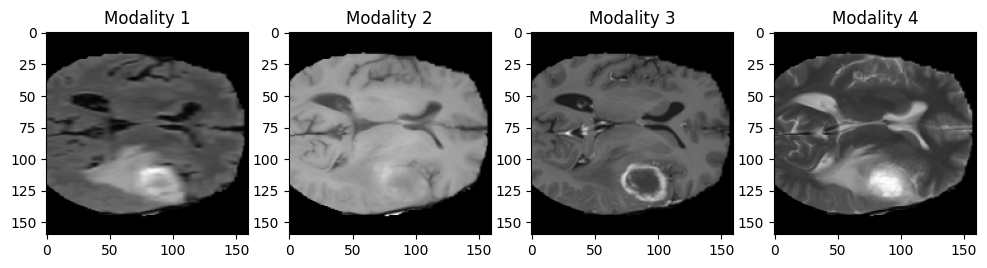

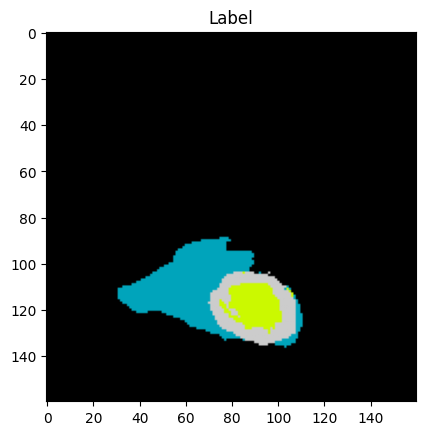

In [9]:
# check
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

nii_file = nib.load("/content/imageTrain/BRATS_001.nii.gz")
img_norm = nii_file.get_fdata()
nii_file = nib.load("/content/labelTrain/BRATS_001.nii.gz")
lbl = nii_file.get_fdata()

print(img_norm.shape)
print(lbl.shape)
print(img_norm[80][80][60][2])
print(lbl[100][120][64])

def show_4_mri_with_labels(volume, label):
  # Create figure for modalities
  plt.figure(figsize=(12, 4))

  # Loop through the 4 modalities
  for i in range(4):
      # Create subplot
      plt.subplot(1, 4, i+1)
      # Display middle slice of current modality
      plt.imshow(volume[..., volume.shape[2]//2, i], cmap='gray')
      """
      ...: all rows, all columns
      volume.shape[2] is the number of slices (DEPTH)
      volume.shape[2] // 2 takes the middle slice index
      i is the modality index (from 0 to 3)
      It's like saying: “Give me the 2D image for the center of the brain, for modality i.”
      The result is a 2D image of shape (H, W).
      """
      # Set modality title
      plt.title(f'Modality {i+1}')

  # Show modality plots
  plt.show()

  # Display middle slice of label
  plt.imshow(label[..., label.shape[2]//2], cmap='nipy_spectral')
  # Set label title
  plt.title('Label')

  # Show label plot
  plt.show()

show_4_mri_with_labels(img_norm, lbl)

# Custom data generator

In [10]:
# labels must be one hot encoded

import tensorflow as tf

def one_hot_encode_label_tf(label, num_classes=4):
    label = tf.convert_to_tensor(label, dtype=tf.int32)
    one_hot = tf.one_hot(label, depth=num_classes)
    return one_hot.numpy()

In [11]:
# function to load a group of .nii.gz files from a folder and return them as a NumPy vector

import os
import numpy as np
import nibabel as nib

def load_list(file_dir, file_list):
    # file_list is a list of filenames like ["BRATS_001.nii.gz", ...]

    vector = []

    for filename in file_list:
        path = os.path.join(file_dir, filename)
        current = nib.load(path).get_fdata()

        if current.ndim == 3: # if label
          current = one_hot_encode_label_tf(current)

        vector.append(current)

    return np.array(vector)

In [12]:
# function to generate the Batch: a vector where each element is a tuple: (image, label)

def batchLoader(img_dir, img_list, label_dir, label_list, batch_size):

    L = len(img_list)

    # Keras requires batches to be provided one at the time
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_list(img_dir, img_list[batch_start:limit])
            Y = load_list(label_dir, label_list[batch_start:limit])

            yield (X,Y)
            # similar to 'return' but it doesn't end the function, it just suspends it.
            # It builds a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

# 3D U-Net

### Instance normalization function

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer="ones",
                                     trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer="zeros",
                                    trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2, 3], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super().get_config()
        config.update({"epsilon": self.epsilon})
        return config

### 3D U-net

In [14]:
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, Dropout, concatenate, Activation
from tensorflow.keras.models import Model

kernel_initializer = 'he_uniform'

def TriDimensional_Unet_Model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    # Contracting path
    c1 = Conv3D(16, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(inputs)
    c1 = InstanceNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c1)
    c1 = InstanceNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = InstanceNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c2)
    c2 = InstanceNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = InstanceNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c3)
    c3 = InstanceNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = InstanceNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c4)
    c4 = InstanceNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = InstanceNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c5)
    c5 = InstanceNormalization()(c5)
    c5 = Activation('relu')(c5)

    # from here, where the 256 volumes have the lowest dimensions (h,w,d), I'd like to get back to the original size (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)

    # Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same', activation=None)(c5)
    u6 = InstanceNormalization()(u6)
    u6 = Activation('relu')(u6)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = InstanceNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c6)
    c6 = InstanceNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same', activation=None)(c6)
    u7 = InstanceNormalization()(u7)
    u7 = Activation('relu')(u7)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = InstanceNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c7)
    c7 = InstanceNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same', activation=None)(c7)
    u8 = InstanceNormalization()(u8)
    u8 = Activation('relu')(u8)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = InstanceNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c8)
    c8 = InstanceNormalization()(c8)
    c8 = Activation('relu')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same', activation=None)(c8)
    u9 = InstanceNormalization()(u9)
    u9 = Activation('relu')(u9)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = InstanceNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation=None, kernel_initializer=kernel_initializer, padding='same')(c9)
    # InstanceNormalization not needed with softmax qui per non interferire con il softmax finale

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9) # 4 channels where, per each voxel, the sum of the four voxels is 1

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

# Training

In [15]:
# define paths and data generator

import os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt

train_img_dir = "/content/imageTrain/"
train_lbl_dir = "/content/labelTrain/"
train_img_list = sorted(os.listdir(train_img_dir))
train_lbl_list = sorted(os.listdir(train_lbl_dir))

test_img_dir = "/content/imageTest/"
test_lbl_dir = "/content/labelTest/"
test_img_list = sorted(os.listdir(test_img_dir))
test_lbl_list = sorted(os.listdir(test_lbl_dir))

batch_size = 2
train_generator = batchLoader(train_img_dir, train_img_list,
                                train_lbl_dir, train_lbl_list, batch_size)
test_generator = batchLoader(test_img_dir, test_img_list,
                                test_lbl_dir, test_lbl_list, batch_size)

### check

BRATS_142.nii.gz
BRATS_142.nii.gz
Image shape:  (2, 160, 160, 128, 4)
Label shape:  (2, 160, 160, 128, 4)


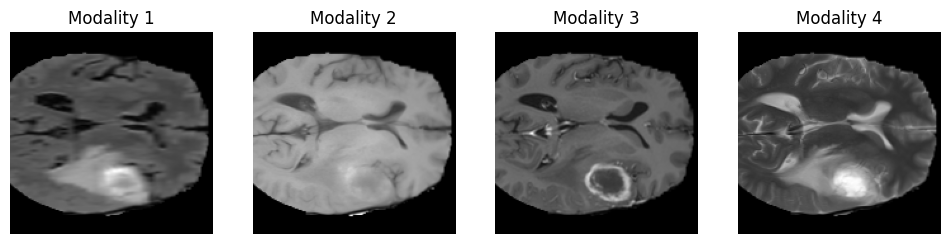

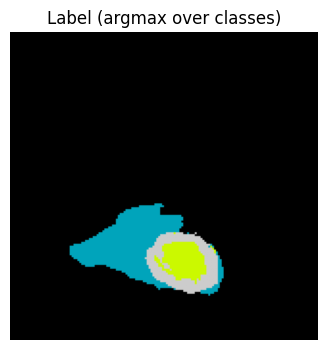

In [16]:
print(train_img_list[100])
print(train_lbl_list[100])


my_datagen = batchLoader(train_img_dir, train_img_list, train_lbl_dir, train_lbl_list, batch_size)
batch_images, batch_labels = next(my_datagen)
print("Image shape: ", batch_images.shape)
print("Label shape: ", batch_labels.shape)

def show_4_mri_with_labels_hot_encoded(volume, label):
    # show the 4 brain resonance modalities
    plt.figure(figsize=(12, 4))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(volume[..., volume.shape[2] // 2, i], cmap='gray')
        plt.title(f'Modality {i + 1}')
        plt.axis('off')
    plt.show()

    # extract the central slice according to depth of the label
    middle_slice = label[..., label.shape[2] // 2, :]  # shape (H, W, num_classes)
    #arg_max on channels for each pixel
    label_slice = np.argmax(middle_slice, axis=-1)     # shape (H, W)

    # show the label
    plt.figure(figsize=(4, 4))
    plt.imshow(label_slice, cmap='nipy_spectral')
    plt.title('Label (argmax over classes)')
    plt.axis('off')
    plt.show()
show_4_mri_with_labels_hot_encoded(batch_images[0], batch_labels[0])

## Generalized Dice loss

In [17]:
import tensorflow as tf

def generalized_dice_loss(y_true, y_pred, smooth=1e-5):
    """
    Generalized Dice Loss for multi-class segmentation.

    Args:
        y_true: one-hot encoded ground truth, shape [batch_size, H, W, D, num_classes]
        y_pred: soft predictions (probabilities), shape [batch_size, H, W, D, num_classes]
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # flatten all spatial dimensions
    y_true_f = tf.reshape(y_true, [tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]])  # [batch_size, N = HxWxD, num_classes]
    y_pred_f = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]])  # [batch_size, N = HxWxD, num_classes]

    # Compute numerator and denominator
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)  # [batch_size, num_classes]
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=1)   # [batch_size, num_classes]

    # Compute weights: inverse squared volume of each class in y_true
    weights = tf.math.reciprocal(tf.reduce_sum(y_true_f, axis=1)**2 + smooth)  # [batch_size, num_classes]

    # Apply weights
    numerator = tf.reduce_sum(weights * intersection, axis=-1)    # [batch_size]
    denominator = tf.reduce_sum(weights * denominator, axis=-1)   # [batch_size]

    dice = (2. * numerator + smooth) / (denominator + smooth)
    loss = 1. - dice  # [batch_size]
    return tf.reduce_mean(loss)  # average over batch


In [18]:
# check on loss
img_norm = nib.load("/content/imageTrain/BRATS_015.nii.gz").get_fdata()
lbl = nib.load("/content/labelTrain/BRATS_015.nii.gz").get_fdata()
lbl_onehot = one_hot_encode_label_tf(lbl)

print(generalized_dice_loss(lbl_onehot, lbl_onehot))

tf.Tensor(0.0, shape=(), dtype=float32)


## Compile and Fit

In [19]:
# define and compile the model

metrics = [keras.metrics.OneHotIoU(num_classes=4, target_class_ids=[0, 1, 2, 3])]
LR = 0.0001
optim = keras.optimizers.Adam(LR)

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(test_img_list)//batch_size

model = TriDimensional_Unet_Model(IMG_HEIGHT=160, IMG_WIDTH=160, IMG_DEPTH=128, IMG_CHANNELS=4, num_classes=4)
model.compile(optimizer=optim, loss=generalized_dice_loss, metrics=metrics)

print(model.input_shape)
print(model.output_shape)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 160, 160,  │      1,744 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 160, 160,  │         32 │ conv3d[0][0]      │
│ (InstanceNormaliza… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 160, 160,  │          0 │ instance_normali… │
│ (Activation)        │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 160, 160,  │          0 │ activation[0][0]  │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 160, 160,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 160, 160,  │         32 │ conv3d_1[0][0]    │
│ (InstanceNormaliza… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 160, 160,  │          0 │ instance_normali… │
│ (Activation)        │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 80, 80,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 80, 80,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 80, 80,    │         64 │ conv3d_2[0][0]    │
│ (InstanceNormaliza… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ instance_normali… │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80, 80,    │          0 │ activation_2[0][… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 80, 80,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 80, 80,    │         64 │ conv3d_3[0][0]    │
│ (InstanceNormaliza… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 80, 80,    │          0 │ instance_normali… │
│ (Activation)        │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 40, 40,    │          0 │ activation_3[0][

 Total params: 5,649,652 (21.55 MB)

 Trainable params: 5,649,652 (21.55 MB)

 Non-trainable params: 0 (0.00 B)

(None, 160, 160, 128, 4)
(None, 160, 160, 128, 4)


In [20]:
#callback to save results

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

In [ ]:
# fit the model

# for each epoch, I split all my train data into 'step_per_epoch' batches of dimension 'batch_size',
# I have 'step_per_epoch' weights update.
# At the end of each epoch I compute the evluation metrics on test set

history=model.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=30,
                  verbose=1,
                  validation_data=test_generator,
                  validation_steps=val_steps_per_epoch,
                  callbacks=[checkpoint_callback]
                  )

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 160, 160, 128, 4))
  warnings.warn(msg)


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.9068 - one_hot_io_u: 0.2277

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 160, 160, 128, 4))
  warnings.warn(msg)



Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_01.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 593s 3s/step - loss: 0.9060 - one_hot_io_u: 0.2280 - val_loss: 0.5925 - val_one_hot_io_u: 0.4165
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.5641 - one_hot_io_u: 0.4567
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_02.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - loss: 0.5640 - one_hot_io_u: 0.4567 - val_loss: 0.5320 - val_one_hot_io_u: 0.4502
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.5158 - one_hot_io_u: 0.4828
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_03.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - loss: 0.5158 - one_hot_io_u: 0.4828 - val_loss: 0.5077 - val_one_hot_io_u: 0.4588
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━

## Restart the training after interruption due to limited gpu (11-21)

In [ ]:
from tensorflow import keras

# load the model from epoch 11
model = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_11.keras',
    custom_objects={
        'InstanceNormalization': InstanceNormalization,
        'generalized_dice_loss': generalized_dice_loss
    },
    compile=True
)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=30,
                    initial_epoch=11,
                    validation_data=test_generator,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[checkpoint_callback]
)

Epoch 12/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4203 - one_hot_io_u: 0.5243
Epoch 12: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_12.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - loss: 0.4202 - one_hot_io_u: 0.5243 - val_loss: 0.4350 - val_one_hot_io_u: 0.4842
Epoch 13/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4283 - one_hot_io_u: 0.5143
Epoch 13: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_13.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - loss: 0.4282 - one_hot_io_u: 0.5144 - val_loss: 0.4177 - val_one_hot_io_u: 0.4881
Epoch 14/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4234 - one_hot_io_u: 0.5161
Epoch 14: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_14.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - loss: 0.4233 - one_hot_io_

## Restart the training after interruption due to limited gpu (21-47)

In [ ]:
from tensorflow import keras

# load the model from epoch 21
model = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_21.keras',
    custom_objects={
        'InstanceNormalization': InstanceNormalization,
        'generalized_dice_loss': generalized_dice_loss
    },
    compile=True
)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    initial_epoch=21,
                    validation_data=test_generator,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[checkpoint_callback]
)

Epoch 22/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3796 - one_hot_io_u: 0.5382
Epoch 22: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_22.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - loss: 0.3797 - one_hot_io_u: 0.5381 - val_loss: 0.4206 - val_one_hot_io_u: 0.5054
Epoch 23/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3644 - one_hot_io_u: 0.5399
Epoch 23: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_23.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - loss: 0.3645 - one_hot_io_u: 0.5398 - val_loss: 0.4004 - val_one_hot_io_u: 0.5080
Epoch 24/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3606 - one_hot_io_u: 0.5427
Epoch 24: saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_24.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - loss: 0.3606 - one_hot_io_

## Restart the training after interruption due to limited gpu (47-)

In [21]:
from tensorflow import keras

# load the model from epoch 47
model = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Deep Learning Project/checkpoints/Generalized Dice loss/epoch_47.keras',
    custom_objects={
        'InstanceNormalization': InstanceNormalization,
        'generalized_dice_loss': generalized_dice_loss
    },
    compile=True
)

# Evaluation

In [22]:
# plot loss and metrics (giustamente non li ho salvati quindi non li stampa)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

iou = history.history['one_hot_io_u']
val_iou = history.history['val_one_hot_io_u']
plt.plot(epochs, iou, 'green', label='Training iou')
plt.plot(epochs, val_iou, 'orange', label='Validation iou')
plt.title('Training and validation iou')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.legend()
plt.show()

NameError: name 'history' is not defined